# Spread options trading

In finance, a spread option is a type of option that is written on the difference of spread of two underlying asset prices. Let $S_1(t)$ and $S_2(t)$ be the prices of the two underlying assets at any point in time $t$. Then the payoff of a European call option written on the spread between $S_1$ and $S_2$ at maturity $T$ and strike price $K$ is $max(S_2(T) - S_1(T) - K,0)$. Spread options are widely used in energy markets for risk management purposes, speculation and arbitrage.

If a cointegration relationship exists between the two underlying asset prices the spread process can be modelled directly using an Ornstein-Uhlenbeck process. 

**Cointegration** is a very important concept when modelling the spread. Two series that are cointegrated are expected to move so that they do not drift too far apart. An example might be the price of natural gas in two different locations. We can see this relationship by studying the graph of the spread between TTF and PVB, two common gas indices. In the figure below we can see that when a shock hits the market the spread widens but with time it returns to its regular level

In [27]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm


#from pykalman import KalmanFilter

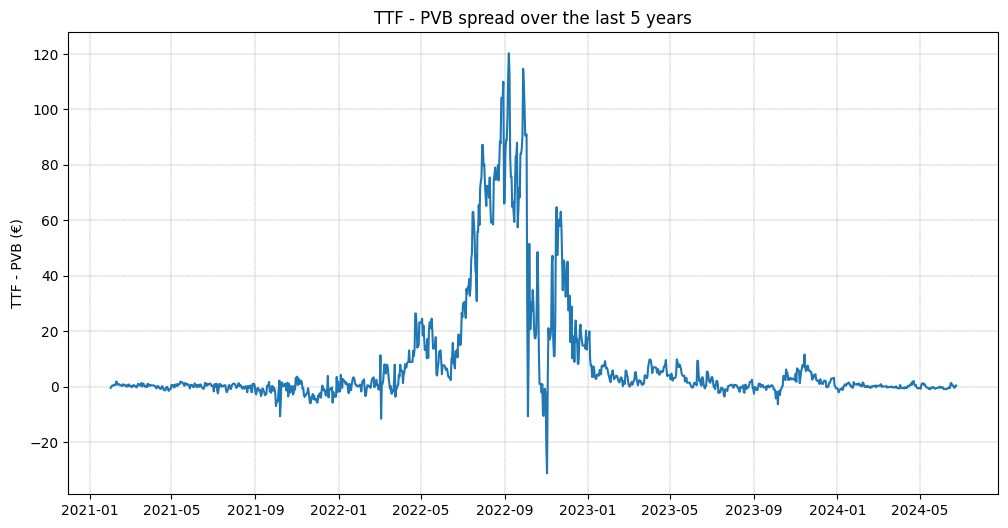

In [ ]:
path = r'C:\Users\ramon\OneDrive\Desktop\Asignaturas\TFM\Python Scripts\Data\ICIS Heren price time series.xlsx'
df = pd.read_excel(path)
df.set_index('Date',drop=True,inplace=True)
df['TTF - PVB spread'] = df['ICIS TTF'] - df['ICIS PVB']

# We select a period to see the graph more clearly
period1 = df.loc['2021-02-01':]

plt.figure(figsize=(12, 6))
plt.plot(period1.index, period1['TTF - PVB spread'])

#plt.xlabel('Time')
plt.ylabel('TTF - PVB (€)')
plt.title('TTF - PVB spread over the last 5 years')
plt.grid(True,linestyle='--', linewidth=0.3, color='gray')
plt.show()

# 1. Data

We will use a dataset dataset that contains daily spot prices of four different gas indices from four European national gas markets: TTF (Netherlands), NBP (United Kingdom), PEG (France) and PVB (Spain).

The data starts in the first of January of the year 2019 and ends on June 23 2023. The dataset contains
a total 2001 observations of each index. TTF, PEG and PVB are measured in eur/MWh while NBP is
measured in pence/therm.

The NBP is converted into eur/MWh using the conversion: 1 therm = 29.3071 kilowatt hours and the daily
GBP/EURexchange rates provided by the European Central Bank in its website. The time series are plotted
in the following graph

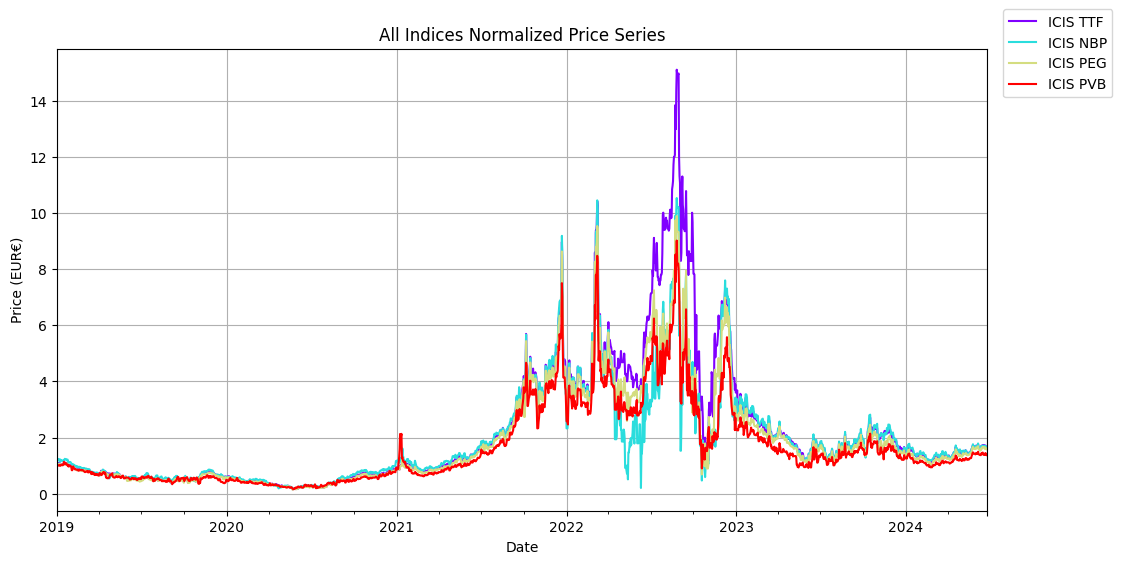

In [ ]:
# Define conversion factors
pence_to_pounds = 1 / 100  # 1 pound = 100 pence
therms_to_mwh = 0.0293071  # 1 therm = 0.0293071 MWh
gbp_to_eur = 1.16  # 1 GBP = 1.16 EUR (A single rate is assumed for simplicity)

df['ICIS NBP'] = df['ICIS NBP'] * pence_to_pounds * therms_to_mwh * gbp_to_eur

n_secs = len(df.columns)
colors = cm.rainbow(np.linspace(0, 1, n_secs))
df.div(df.iloc[0,:]).plot(color=colors, figsize=(12, 6))
plt.title('All Indices Normalized Price Series')
plt.xlabel('Date')
plt.ylabel('Price (EUR€)')
plt.grid(True, which='major', axis='both')
plt.legend(bbox_to_anchor=(1.01, 1.1), loc='upper left', ncol=1)
plt.show();

# Cointegration tests

First we will study the spread process of TTF and PVB.

## 1- Engle-Granger

The Engle-Granger cointegration test is a procedure used to determine if there is a long-term relationship (cointegration) between two or more non-stationary time series. The concept of cointegration is crucial in econometrics and time series analysis, as it allows for the identification of long-term equilibrium relationships between variables that, individually, might be non-stationary.

### First step: Checking for stationarity of the series

To verify stationarity in the ADF test, the ADF statistic must be compared with the critical values and the p-value considered. If the ADF statistic is less than the critical values or the p-value is less than 0.05, the series is considered stationary. If not, the series is non-stationary.

In [13]:
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}') 
    return result[1]

# Extraer las series temporales
TTF = df['ICIS TTF']
PVB = df['ICIS PVB']

# Verificar la estacionariedad
print("Test ADF para TTF:")
check_stationarity(TTF)

print("\nTest ADF para PVB:")
check_stationarity(PVB)

Test ADF para TTF:
ADF Statistic: -2.3023454744673804
p-value: 0.17121262518346692
Critial Values:
   1%, -3.433665351698571
Critial Values:
   5%, -2.8630045337025267
Critial Values:
   10%, -2.567549656849864

Test ADF para PVB:
ADF Statistic: -2.3296260194428475
p-value: 0.16259091460254937
Critial Values:
   1%, -3.4336536273681078
Critial Values:
   5%, -2.862999357426174
Critial Values:
   10%, -2.567546900734257


0.16259091460254937

### Second step: Fit the OLS regression and obtain the residuals

In [14]:
TTF_w_constant = sm.add_constant(TTF)  # Add a constant
model = sm.OLS(PVB, TTF_w_constant).fit()
residuals = model.resid  # Residuals

### Third step: Run the ADF test on the residuals
If the residuals are stationary, we can conclude that the two series are cointegrated.

In [18]:
print("\nADF test for the residuals:")
p_value = check_stationarity(residuals)

if p_value < 0.05:
    print("The series are cointegrated (enough evidence to reject the null hypothesis H0 of a unit root in the residuals).")
else:
    print("The series don't seem to be cointegrated (not enough evidence to reject H0).")


ADF test for the residuals:
ADF Statistic: -3.648810781510247
p-value: 0.0048935836164940415
Critial Values:
   1%, -3.43366703339965
Critial Values:
   5%, -2.8630052761696607
Critial Values:
   10%, -2.567550052177805
The series are cointegrated (enough evidence to reject the null hypothesis H0 of a unit root in the residuals).


### 2. Another option to check for cointegration is to use the function "coint" from statsmodels:
This function runs the process described above directly

In [19]:
# Volvemos a cargar las series para excluir la constante en x
TTF = df['ICIS TTF']
PVB = df['ICIS PVB']

np_TTF = np.array(TTF)
np_PVB = np.array(PVB)

coint_t, p_value, critical_values = coint(PVB, TTF)  
print(f'Cointegration test (t-statistic): {coint_t}')
print(f'p-value: {p_value}')
print(f'Critical values: {critical_values}')

if p_value < 0.05:
    print("The series are cointegrated (enough evidence to reject the null hypothesis H0 of a unit root in the residuals).")
else:
    print("The series don't seem to be cointegrated (not enough evidence to reject H0).")

Cointegration test (t-statistic): -3.649741470057513
p-value: 0.02123501326541795
Critical values: [-3.90192433 -3.33918676 -3.04657128]
The series are cointegrated (enough evidence to reject the null hypothesis H0 of a unit root in the residuals).


## One factor model

Now that we have checked for cointegration between the two time series, let's develop a one factor model for the spread process.

Let's consider a one-factor model of the spot spread in the risk neutral measure specified by:
$$
	d\boldsymbol{x}_t = \theta(\mu - x_t)dt + \sigma d\boldsymbol{W}_t 
$$

where:
- $\theta$ is the mean reversion speed

- $\mu$ is the long-run mean of the spread process

- $\sigma$ is the volatility

- $\boldsymbol{W}_t$ is a standard Wiener process (Brownian motion).

Solving the Stochastic Differential Equation (SDE) given a starting time $t_0$ we obtain:
$$
	\boldsymbol{x}_t = x_{t_0} e^{-\theta(t-t_0)} + \mu (1 - e^{-\theta(t-t_0)}) + \sigma e^{-\theta t} \int_{t_0}^t e^{\theta s} \, d\boldsymbol{W}_s
$$
which follows a normal distribution at time $t_0$ with mean
$$
	a_t = x_{t_0} e^{-\theta(t-t_0)} + \mu (1 - e^{-\theta(t-t_0)})
$$
and standard deviation 
$$
	b_t = \sqrt{\frac{1-e^{-2\theta(t-t_0)}}{2\theta}}\sigma
$$

Define $F(t,T,x_t)$ as the futures spread ( the spread of two futures prices) of maturity $T$ observed in the market at time $t$ when the spot spread is $x_t$. In the risk neutral measure the spot spread process$x$ must satisfy the no arbitrage condition:
$$
	\mathbb{E}\left[\boldsymbol{x}_T | x_t\right] = F(t,T,x_t)
$$

i.e. in the absence of arbitrage the conditional expectation with respect to the spot spread $x_t$ of the out-turn spot spread at T in the risk-neutral measure is the futures spread observed at time $t<T$. This must hold because it is costless to enter a futures spread (long one future and short the other). From (12) and the no arbitrage constraint (15) we have 
$$
	F(t,T,x_t) = x_{t} e^{-\theta(T-t)} + \mu (1 - e^{-\theta(T-t)})
$$

## Spread process in the market measure

A risk adjusted version of the models is needed in order to be able to calibrate the using market data. Instead of using a risk neutral measure, we will use a real-world measure that incorporates investors' risk aversion through the risk premium $\lambda$. This premium incorporates one additional degree of freedom to the model, adjusting the drift term of the process to reflect the actual observed behavior of the market, rather than the risk-neutral behavior.
$$
	d\boldsymbol{x}_t = \left[\theta(\mu - x_t) - \lambda\right]dt + \sigma d\boldsymbol{W}_t 
$$

# Calibration

We will use the log-likelyhood function to calibrate the model. 

First we will calibrate a samaller period of time for simplicity. The period selected gooes from January 1st, 2024 to the last datapoint which is from June 23, 2024. Then we will use the full dataset to see how it impacts the valuation of the options.

In [22]:
# Load dataset from Excel file
path = r'C:\Users\ramon\OneDrive\Desktop\Asignaturas\TFM\Python Scripts\Data\ICIS Heren price time series since 2024 01 01.xlsx'
df = pd.read_excel(path)
df.set_index('Date', drop=True, inplace=True)

PVB_TTF_spread = df['ICIS PVB'] - df['ICIS TTF']
df['PVB - TTF spread'] = PVB_TTF_spread

Note that an initial value of the parameters must be provided for the optimization. It has been tested that this initial value does not affect the output significantly.

Also note that the calibration can be done either using a discrete form of the SDE or using the integrated equation for each time step. Here we directly calibrate the parameters using the SDE (the second option is provided in the commented lines, simply changing mu_x and var_x). The results are very similar.

In [23]:
# Define the log-likelihood function for the one-factor model with robust estimation
def log_likelihood_robust(params, data):
    theta, mu, sigma, lambd = params
    n = len(data)
    dt = 1 / 365 # Assuming constant time steps
    
    x_t = data
    
    # Calculate the increments
    dx = np.diff(x_t)

    # Calculate the conditional means
    mu_dx = (theta * (mu - x_t[:-1]) + lambd) * dt
    #mu_dx = x_t[:-1] * np.exp(-theta * dt) + (mu + lambd / theta) * (1 - np.exp(-theta * dt)) - x_t[:-1]

    # Calculate the conditional variances
    var_dx = sigma ** 2 * dt
    #var_dx = (1 - np.exp(-2* theta *dt)) / (2 * theta) * (sigma ** 2)

    # Apply weights to reduce the impact of outliers
    residuals = dx - mu_dx
    weights = np.where(np.abs(residuals) > np.percentile(np.abs(residuals), 80), 1, 1)
    
    # Weighted Log-likelihood
    ll = 0
    for i in range(n - 1):
        delta = dx[i] - mu_dx[i]
        ll += -0.5 * weights[i] * (np.log(2 * np.pi * var_dx) + (delta ** 2) / var_dx)
    return -ll  # Negative because we are minimizing

# Initial parameter guesses using robust statistics
initial_mu = np.median(PVB_TTF_spread)
initial_sigma = np.median(np.abs(np.diff(PVB_TTF_spread)))
initial_params = [0.1, initial_mu, initial_sigma, 0.0]
#initial_params = [0.1, 0.1, 0.1, 0.0]


print(initial_mu)
print(initial_sigma)

# Optimization
result = minimize(log_likelihood_robust, initial_params, args=(df['PVB - TTF spread'].values,), method='L-BFGS-B')
theta_hat_robust, mu_hat_robust, sigma_hat_robust, lambd_hat_robust = result.x

def print_params(params):
    param_names = ['theta', 'mu', 'sigma', 'lambda']
    for name, value in zip(param_names, params):
        print(f'{name} = {value:.4f}')

print_params([theta_hat_robust, mu_hat_robust, sigma_hat_robust, lambd_hat_robust])

0.10000000000000142
0.21899999999999942
theta = 86.4798
mu = -0.0060
sigma = 8.2644
lambda = -4.5466


## Simulation of the spread using the estimated parameters

Now we will use the parameters obtained to simulate the spread process given by the one-factor model and graphically compare it to the true spread process observed in the market.

C:\Users\ramon\AppData\Local\Temp\ipykernel_31528\3746691774.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  simulated_x_sde, simulated_x_analytical = simulate_ou_process_robust_sde_and_analytical([theta_hat, mu_hat, sigma_hat, lamb_hat], PVB_TTF_spread[0], len(PVB_TTF_spread))


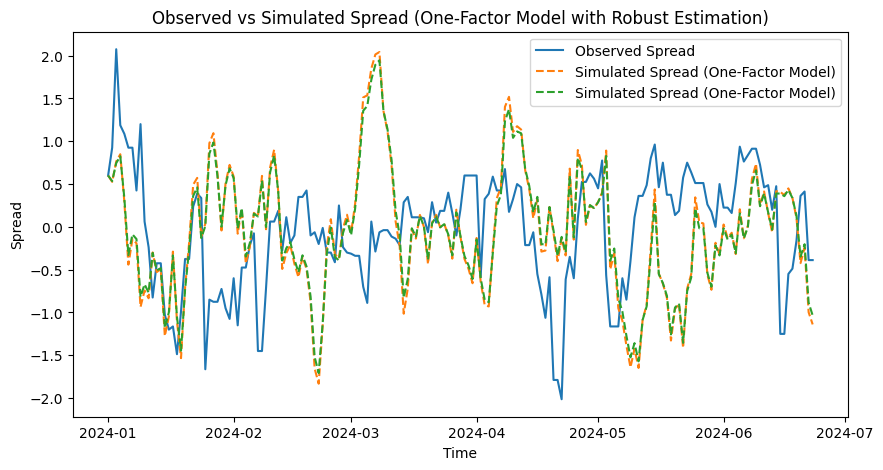

In [24]:
# Simulation of the time series using the estimated parameters
def simulate_ou_process_robust_sde_and_analytical(params, x0, n):
    theta, mu, sigma, lambd= params
    dt = 1 / 365  # Assuming constant time steps
    x_sde = np.zeros(n)
    x_sde[0] = x0
    x_analytical = np.zeros(n)
    x_analytical[0] = x0
    for t in range(1, n):
        W = np.random.normal()
        dx = (theta * (mu - x_sde[t-1]) + lambd) * dt + sigma * np.sqrt(dt) * W
        x_sde[t] = x_sde[t-1] + dx
        x_analytical[t] = x_analytical[t-1] * np.exp(-theta * dt) + (mu + lambd / theta) * (1 - np.exp(-theta * dt)) + sigma * np.sqrt((1 - np.exp(-2 * theta * dt)) / (2 * theta)) * W
    return x_sde, x_analytical

# Estimated parameters
theta_hat, mu_hat, sigma_hat, lamb_hat = theta_hat_robust, mu_hat_robust, sigma_hat_robust, lambd_hat_robust

# Simulation of the process
simulated_x_sde, simulated_x_analytical = simulate_ou_process_robust_sde_and_analytical([theta_hat, mu_hat, sigma_hat, lamb_hat], PVB_TTF_spread[0], len(PVB_TTF_spread))

simulated_df = pd.DataFrame({
    'simulated_x_sde': simulated_x_sde,
    'simulated_x_analytical': simulated_x_analytical
})

simulated_df.to_excel('simulation sde and analytical.xlsx', index=False)

# Visual comparison
plt.figure(figsize=(10, 5))
plt.plot(df.index, PVB_TTF_spread, label='Observed Spread')
plt.plot(df.index, simulated_x_sde, label='Simulated Spread (One-Factor Model)', linestyle='--')
plt.plot(df.index, simulated_x_analytical, label='Simulated Spread (One-Factor Model)', linestyle='--')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Spread')
plt.title('Observed vs Simulated Spread (One-Factor Model with Robust Estimation)')
plt.show()

# Straddle option valuation

Now we will use the model to value a straddle option on the spread of TTF and PVB.

The initial parameters are given by the calibration process done before. For the rest we make some assumptions.

In [28]:
# Parameters from the table
strike_price = 0  # €/MWh
maturity = 0.5  # 6 months expressed in years
risk_free_rate = 2.749 / 100  # Convert to decimal
mean_reversion_speed = theta_hat_robust  # θ
long_term_mean = mu_hat_robust  # μ
volatility = sigma_hat_robust  # σ
initial_spread = 0  # Assuming the initial spread is zero
num_simulations = 100000  # Number of simulations to get expected payoff
dt = 1 / 365  # Time step size (1 day)
time_steps = int(maturity * 365)  # Time steps corresponding to 6 months (daily)
transaction_cost = 0  # Adjust the transaction cost here

### Perform the pricing using the closed-form approach for the straddle

In [29]:
# Closed-form pricing function for straddle
def closed_form_straddle_price(theta, mu, sigma, S0, T, r, K):
    # Calculate expected value (a_s) and standard deviation (b_s) of the spread at maturity
    a_s = S0 * np.exp(-theta * T) + mu * (1 - np.exp(-theta * T))
    b_s = np.sqrt((sigma**2 / (2 * theta)) * (1 - np.exp(-2 * theta * T)))

    # Discount factor (B)
    B = np.exp(-r * T)

    # Calculate d1 for the CDF of the normal distribution
    d1 = (a_s - K) / b_s

    # Price of the call option (using the closed-form formula)
    call_price = B * ((b_s / np.sqrt(2 * np.pi)) * np.exp(-d1**2 / 2) + (a_s - K) * norm.cdf(d1))

    # Price of the put option (using the closed-form formula)
    put_price = B * ((b_s / np.sqrt(2 * np.pi)) * np.exp(-d1**2 / 2) + (K - a_s) * norm.cdf(-d1))

    # Straddle price is the sum of the call and put prices
    straddle_price = call_price + put_price
    
    return straddle_price

straddle_price = closed_form_straddle_price(mean_reversion_speed, long_term_mean, volatility, initial_spread, maturity, risk_free_rate, strike_price)

print(f"The straddle option price using the closed-form approach is: {straddle_price:.4f} €/MWh")

The straddle option price using the closed-form approach is: 0.4946 €/MWh


### Perform the pricing using the Monte Carlo approach

In [30]:
# Function to simulate the spread evolution using the discrete-time approximation for a straddle
def simulate_mc_paths_discrete_ou_straddle(theta, mu, sigma, S0, maturity, num_simulations, dt, time_steps):
    payoffs = np.zeros(num_simulations)
    final_spread_values = np.zeros(num_simulations)

    for i in range(num_simulations):
        spread_values = np.zeros(time_steps + 1)
        spread_values[0] = S0

        for t in range(1, time_steps + 1):
            # Random component for each time step
            dW = np.random.normal()
            
            # Update formula using discrete-time approximation of OU process
            spread_values[t] = spread_values[t-1] * np.exp(-theta * dt) + mu * (1 - np.exp(-theta * dt)) + sigma * np.sqrt((1 - np.exp(-2 * theta * dt)) / (2 * theta)) * dW

        # Final spread value at maturity
        S_T = spread_values[-1]
        final_spread_values[i] = S_T

        # Payoff for a European straddle option (both call and put)
        payoffs[i] = max(S_T - strike_price, 0) + max(strike_price - S_T, 0)

    # Calculate the expected payoff
    expected_payoff = np.mean(payoffs)

    # Discount the expected payoff to present value
    discounted_payoff = np.exp(-risk_free_rate * maturity) * expected_payoff
    
    return discounted_payoff, final_spread_values, payoffs

# Perform the pricing using the Monte Carlo approach with discrete-time approximation for a straddle
price_mc_straddle, final_spread_values_mc_straddle, payoffs_mc_straddle = \
simulate_mc_paths_discrete_ou_straddle(mean_reversion_speed, long_term_mean, volatility, initial_spread, maturity, num_simulations, dt, time_steps)

print(f"The straddle option price using the Monte Carlo approach is: {price_mc_straddle:.4f} €/MWh")

The straddle option price using the Monte Carlo approach is: 0.4943 €/MWh


### Now we plot the distributions of the spread value and the payoff at maturity using Montecarlo for the simulations

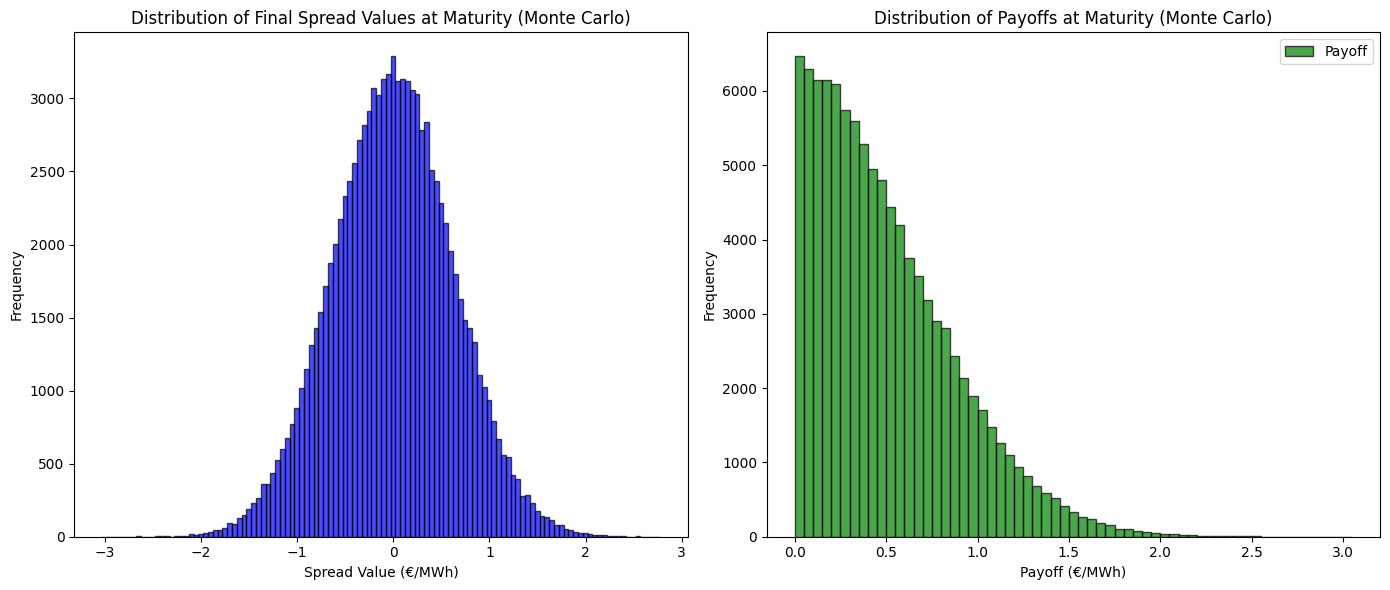

In [31]:
# Adjust the bins for both positive and negative x-axis values with 0.05 €/MWh intervals
bin_width = 0.05

# Define the bin edges for the spread values (symmetric around 0)
min_spread = min(np.min(final_spread_values_mc_straddle), 0)
max_spread = np.max(final_spread_values_mc_straddle)
bins_spread = np.arange(min_spread, max_spread + bin_width, bin_width)

# Define the bin edges for payoffs (only positive values with 0.05 €/MWh intervals)
max_payoff = np.max(payoffs_mc_straddle)
bins_payoff = np.arange(0, max_payoff + bin_width, bin_width)

# Plotting the distributions
plt.figure(figsize=(14, 6))

# Plot 1: Distribution of final spread values at maturity (symmetric binning)
plt.subplot(1, 2, 1)
plt.hist(final_spread_values_mc_straddle, bins=bins_spread, edgecolor='black', color='blue', alpha=0.7)
plt.title('Distribution of Final Spread Values at Maturity (Monte Carlo)')
plt.xlabel('Spread Value (€/MWh)')
plt.ylabel('Frequency')

# Plot 2: Distribution of Payoffs (only positive payoffs)
plt.subplot(1, 2, 2)

# Plot non-zero payoffs
plt.hist(payoffs_mc_straddle, bins=bins_payoff, edgecolor='black', alpha=0.7, color='green', label='Payoff')

plt.title('Distribution of Payoffs at Maturity (Monte Carlo)')
plt.xlabel('Payoff (€/MWh)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

## Binomial tree model for European Straddle pricing

In [32]:
def binomial_tree_spread_european_straddle_non_censored(theta, mu, sigma, S0, T, r, K, time_steps, dt):
    # Initialize the binomial tree for option prices
    tree = np.zeros((time_steps + 1, time_steps + 1))

    # Step 1: Calculate spread values and payoffs at the final time step (t=time_steps)
    for i in range(time_steps + 1):
        # Spread value at the final time step after i upward and (time_steps - i) downward movements
        S_T = S0 + (2 * i - time_steps) * sigma * np.sqrt(dt)  # Spread value after additive movements
        # Straddle payoff is the sum of both call and put payoffs
        tree[i, time_steps] = max(S_T - K, 0) + max(K - S_T, 0)  # Straddle payoff at maturity

    # Step 2: Backward induction to calculate option prices at each node
    for t in range(time_steps - 1, -1, -1):
        for i in range(t + 1):
            # Calculate the spread value at this node
            S_t = S0 + (2 * i - t) * sigma * np.sqrt(dt)  # Spread value at node (i, t)
            
            # Calculate the moment-matching probability formula using the current spread S_t
            p = 0.5 + 0.5 * (theta * (-(S_t - mu)) * np.sqrt(dt)) / np.sqrt(theta**2 * (-(S_t - mu))**2 * dt + sigma**2)
            
            # Ensure probabilities remain between 0 and 1
            p = max(0, min(p, 1))
            
            # Calculate the option price at this node using backward induction
            tree[i, t] = np.exp(-r * dt) * (p * tree[i + 1, t + 1] + (1 - p) * tree[i, t + 1])

    return tree

# Build the binomial tree for the straddle using the non-censored method
tree_straddle = binomial_tree_spread_european_straddle_non_censored(mean_reversion_speed, long_term_mean, volatility, initial_spread, maturity, risk_free_rate, strike_price, time_steps * 24, dt/24)

# Perform the pricing using the moment-matching probability formula
price_binomial_spread_straddle_moment_matching = tree_straddle[0, 0]

print(f"The option price for the European Straddle using the moment-matching formula is: {price_binomial_spread_straddle_moment_matching:.4f} €/MWh")

The option price for the European Straddle using the moment-matching formula is: 0.4931 €/MWh


### Plot the Binomial Tree with its probabilities at each node

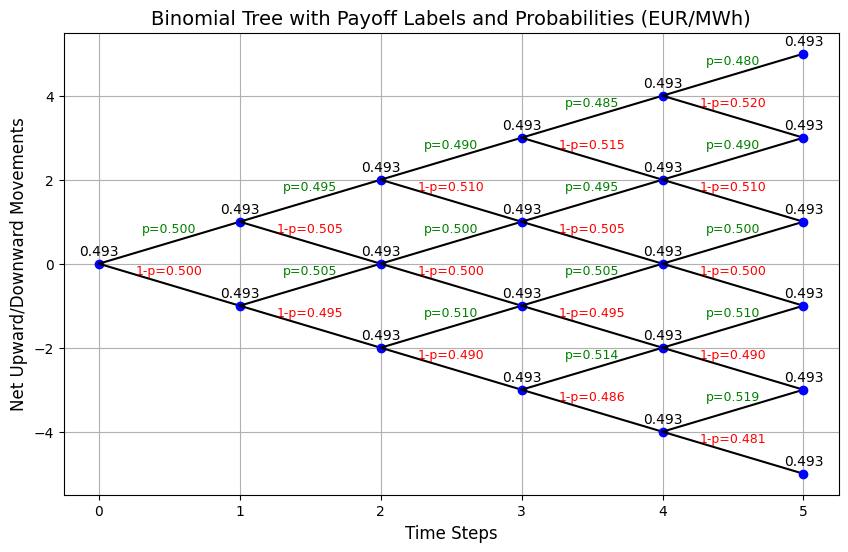

In [33]:
def plot_binomial_tree_with_probabilities(tree, time_steps, theta, mu, sigma, S0, dt):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for t in range(time_steps + 1):  # Loop over each time step
        for i in range(t + 1):  # Loop over each possible node at time t
            # X-axis: time step (t)
            # Y-axis: net upward minus downward movements (i - (t - i) = 2*i - t)
            y_position = 2 * i - t
            ax.plot(t, y_position, 'bo')  # Plot the node as a blue dot
            
            # Add text label for the payoff at this node, placed slightly above the node for clarity
            ax.text(t, y_position + 0.2, f"{tree[i, t]:.3f}", fontsize=10, ha='center')
            
            # Only draw lines and calculate probabilities if not at the final time step
            if t < time_steps:
                # Connect to the upward movement
                y_up = 2 * (i + 1) - (t + 1)
                ax.plot([t, t + 1], [y_position, y_up], 'k-')  # Black line for upward movement
                
                # Connect to the downward movement
                y_down = 2 * i - (t + 1)
                ax.plot([t, t + 1], [y_position, y_down], 'k-')  # Black line for downward movement
                
                # Calculate current spread at node S_t
                S_t = S0 + (2 * i - t) * sigma * np.sqrt(dt)
                
                # Calculate the probability of upward movement
                p = 0.5 + 0.5 * (theta * (-(S_t - mu)) * np.sqrt(dt)) / np.sqrt(theta**2 * (-(S_t - mu))**2 * dt + sigma**2)
                p = max(0, min(p, 1))  # Ensure probability is between 0 and 1
                
                # Label the upward probability on the line
                ax.text(t + 0.5, (y_position + y_up + 0.5) / 2, f"p={p:.3f}", fontsize=9, color='green', ha='center')
                
                # Label the downward probability on the line (1-p for downward movement)
                ax.text(t + 0.5, (y_position + y_down + 0.5) / 2, f"1-p={1 - p:.3f}", fontsize=9, color='red', ha='center')

    # Customize X-axis to only show integers (time steps)
    # ax.set_xticks(range(time_steps + 1))  # Set the X-axis ticks to integer time steps
    
    # Add a title specifying that the payoffs are labeled in EUR/MWh
    ax.set_title('Binomial Tree with Payoff Labels and Probabilities (EUR/MWh)', fontsize=14)
    ax.set_xlabel('Time Steps', fontsize=12)
    ax.set_ylabel('Net Upward/Downward Movements', fontsize=12)
    plt.grid(True)
    plt.show()

# Call the plotting function with probabilities up to 5 time_steps
plot_binomial_tree_with_probabilities(tree_straddle, 5, mean_reversion_speed, long_term_mean, volatility, initial_spread, dt/24)